In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from haversine import haversine
import pickle
from geopy.distance import geodesic
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

In [2]:
#Set working directory
os.chdir("C:/Data science/Project/Cab_fare_prediction")
os.getcwd()

'C:\\Data science\\Project\\Cab_fare_prediction'

In [3]:
#load the data
Cab_train=pd.read_csv("train_cab.csv",dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
Cab_test=pd.read_csv("test.csv")

In [4]:
Cab_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
Cab_train.shape

(16067, 7)

In [6]:
Cab_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
Cab_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(6), object(1)
memory usage: 878.7+ KB


In [6]:
#Convert pickup_datetime from Object to Datetime object
Cab_train['pickup_datetime']=pd.to_datetime(Cab_train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC',errors='coerce')
#Cab_train.head()
Cab_test['pickup_datetime']=pd.to_datetime(Cab_test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC',errors='coerce')

In [9]:
Cab_train.isnull().sum()

fare_amount          25
pickup_datetime      1 
pickup_longitude     0 
pickup_latitude      0 
dropoff_longitude    0 
dropoff_latitude     0 
passenger_count      55
dtype: int64

In [10]:
Cab_train['pickup_datetime'].count()

16066

In [11]:
Cab_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


## Exploratory Data Analysis
Distribution of Trip Fare

In [7]:
Cab_train.loc[Cab_train['fare_amount']<1].shape

(5, 7)

There are few records with negative fare and 0 fare it doesn't make any sence,so We will remove these records from the data

In [8]:
Cab_train = Cab_train.drop(Cab_train[Cab_train['fare_amount']<1].index, axis=0)

Text(0.5, 1.0, 'Distribution of Trip Fare')

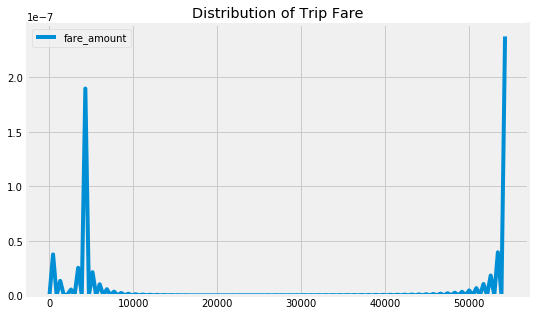

In [9]:
plt.figure(figsize=(8,5))
sns.kdeplot(Cab_train['fare_amount']).set_title("Distribution of Trip Fare")

We can see there are outliers in fare amount we will delete those in outlier analysis 

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

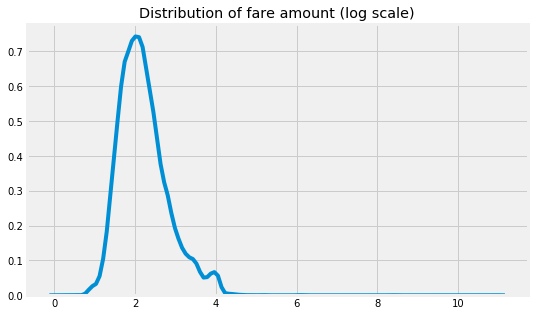

In [15]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(Cab_train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

Distributaion of Passenger_count

In [16]:
#Checking passenger_count less than 1
Cab_train.loc[Cab_train['passenger_count']<1].shape

(58, 7)

In [17]:
#Checking passenger_count greater than 7
Cab_train.loc[Cab_train['passenger_count']>7].shape

(20, 7)

In [10]:
#Checking passenger_count range 
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(Cab_train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


In [19]:
Cab_test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In passenger_count variable, we observerd that few values are less than 1 and more than 7 in cab it is not possible 
And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset 
then it will create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
so we will delete this passenger count values which are less than 1 and greater than 7


In [11]:
Cab_train = Cab_train.drop(Cab_train[Cab_train['passenger_count']>7].index, axis=0)
Cab_train = Cab_train.drop(Cab_train[Cab_train['passenger_count']<1].index, axis=0)

In [12]:
Cab_train.loc[Cab_train['passenger_count']<1].shape

(0, 7)

Text(0.5, 1.0, 'Distribution of passenger count')

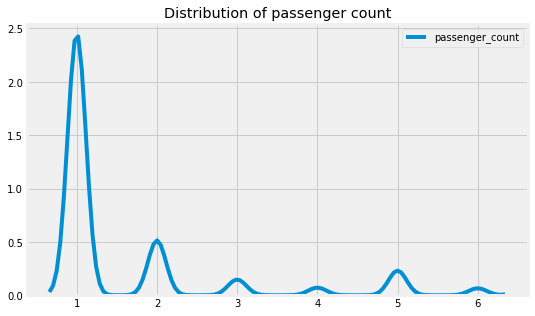

In [22]:
plt.figure(figsize=(8,5))
sns.kdeplot(Cab_train['passenger_count']).set_title("Distribution of passenger count")

### Let us look at Geographical Features
Distribution of Pickup and Dropoff Lat Lng

In [23]:
#Checking latitude and longitude ranges in train data
print("Range of Pickup Latitude is ", (min(Cab_train['pickup_latitude']),max(Cab_train['pickup_latitude'])))

Range of Pickup Latitude is  (-74.006893, 401.083332)


In [24]:
print("Range of Dropoff Latitude is ", (min(Cab_train['dropoff_latitude']),max(Cab_train['dropoff_latitude'])))

Range of Dropoff Latitude is  (-74.006377, 41.366138)


In [25]:
print("Range of Dropoff Latitude is ", (min(Cab_train['pickup_longitude']),max(Cab_train['pickup_longitude'])))

Range of Dropoff Latitude is  (-74.438233, 40.766125)


In [26]:
print("Range of Dropoff Latitude is ", (min(Cab_train['dropoff_longitude']),max(Cab_train['dropoff_longitude'])))

Range of Dropoff Latitude is  (-74.42933199999999, 40.802437)


In [27]:
#Checking latitude and longitude ranges in test data
print("Longitude Boundary in test data")
min(Cab_test.pickup_longitude.min(), Cab_test.dropoff_longitude.min()),max(Cab_test.pickup_longitude.max(), Cab_test.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [28]:
print("Latitude Boundary in test data")
min(Cab_test.pickup_latitude.min(), Cab_test.pickup_latitude.min()),max(Cab_test.pickup_latitude.max(), Cab_test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

Based on test data boundaries, in train data we have outliers in pickup_latitude variable 

In [13]:
#checking whether these values having 0 values 
Cab_train[(Cab_train.pickup_latitude==0) | (Cab_train.pickup_longitude)==0 | (Cab_train.dropoff_latitude==0)|(Cab_train.dropoff_longitude==0)].shape

(312, 7)

In [14]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

Cab_train.loc[~((Cab_train.pickup_longitude >= boundary['min_lng'] ) & (Cab_train.pickup_longitude <= boundary['max_lng']) &
            (Cab_train.pickup_latitude >= boundary['min_lat']) & (Cab_train.pickup_latitude <= boundary['max_lat']) &
            (Cab_train.dropoff_longitude >= boundary['min_lng']) & (Cab_train.dropoff_longitude <= boundary['max_lng']) &
            (Cab_train.dropoff_latitude >=boundary['min_lat']) & (Cab_train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
Cab_train.loc[((Cab_train.pickup_longitude >= boundary['min_lng'] ) & (Cab_train.pickup_longitude <= boundary['max_lng']) &
            (Cab_train.pickup_latitude >= boundary['min_lat']) & (Cab_train.pickup_latitude <= boundary['max_lat']) &
            (Cab_train.dropoff_longitude >= boundary['min_lng']) & (Cab_train.dropoff_longitude <= boundary['max_lng']) &
            (Cab_train.dropoff_latitude >=boundary['min_lat']) & (Cab_train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(Cab_train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
Cab_train=Cab_train.loc[Cab_train['is_outlier_loc']==0]
Cab_train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    15634
1.0    350  
Name: is_outlier_loc, dtype: int64


(-74.03, -73.75)

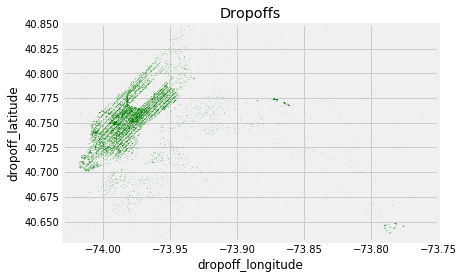

In [15]:
#Plot Heatmap of Pickups and Dropoffs 
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

Cab_train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

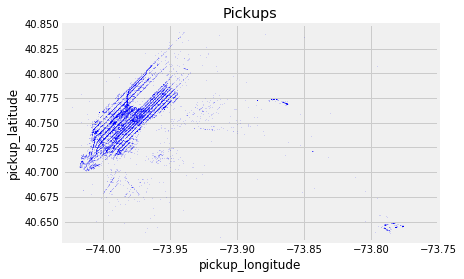

In [16]:
Cab_train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

# Missing Value Analysis 

In [17]:
#Missing values in each variable-
missing_val=pd.DataFrame(Cab_train.isnull().sum())
missing_val=(missing_val/len(Cab_train))*100
missing_val.columns=['Percentage']
missing_val=missing_val.reset_index()
#missing_val
missing_val=missing_val.rename(columns={'index':'Variables',})
missing_val

,Variables,Percentage
0,fare_amount,0.140719
1,pickup_datetime,0.006396
2,pickup_longitude,0.000000
3,pickup_latitude,0.000000
4,dropoff_longitude,0.000000
5,dropoff_latitude,0.000000
6,passenger_count,0.351797


In [18]:
#We decided to drop all the missing values in data set
Cab_train=Cab_train.dropna()

# Outlier Analysis

In [19]:
#copy of data
df1= Cab_train.copy()
#Cab_train= df1.copy()

In [36]:
df1.shape

(15556, 7)

In [37]:
Cab_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15556 entries, 0 to 16065
Data columns (total 7 columns):
fare_amount          15556 non-null float64
pickup_datetime      15556 non-null datetime64[ns]
pickup_longitude     15556 non-null float64
pickup_latitude      15556 non-null float64
dropoff_longitude    15556 non-null float64
dropoff_latitude     15556 non-null float64
passenger_count      15556 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 972.2 KB


In [20]:
#saving all continuous variables in one data frame
cnames=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount']

pickup_longitude


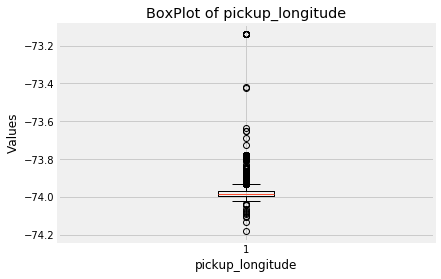

pickup_latitude


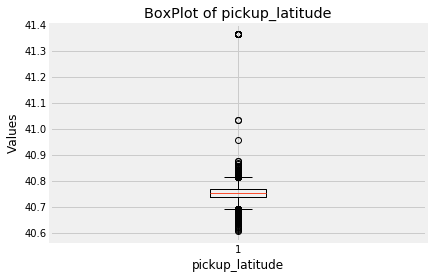

dropoff_longitude


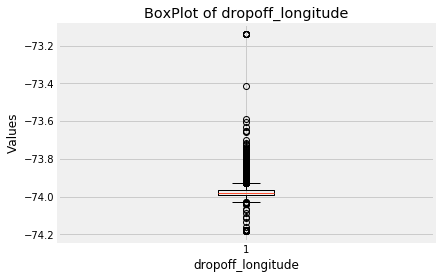

dropoff_latitude


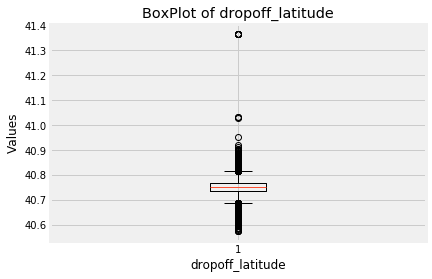

fare_amount


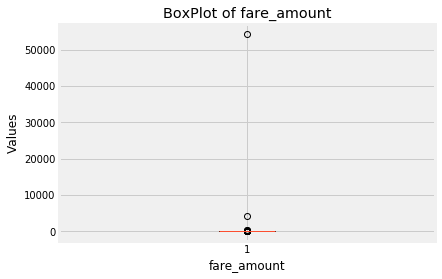

In [21]:
##Plot boxplot to visulazie outliers-
for i in cnames:
    print(i)
    plt.boxplot(Cab_train[i])
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.title("BoxPlot of "+i)
    plt.show()

In [22]:
##Calculate iqr, lower fence and upper fence-
for i in cnames:
    print(i)
    q75,q25= np.percentile(Cab_train.loc[:,i],[75,25])
    iqr= q75-q25
    minimum= q25-(iqr*1.5)
    maximum= q75+(iqr*1.5)
    print(minimum)
    print(maximum)
    print(iqr)
    Cab_train=Cab_train.drop(Cab_train[Cab_train.loc[:,i] < minimum].index)
    Cab_train=Cab_train.drop(Cab_train[Cab_train.loc[:,i] > maximum].index)


pickup_longitude
-74.02877313125
-73.93169652125002
0.02426915249999695
pickup_latitude
40.69273876874998
40.81111313875001
0.029593592500006594
dropoff_longitude
-74.02877425625002
-73.92960984625
0.024791102500003603
dropoff_latitude
40.69245499
40.81290835
0.030113339999999766
fare_amount
-2.1000000000000005
18.700000000000003
5.2


In [23]:
Cab_train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# Feature Extraction

Create datetime features based on pickup_datetime

In [24]:
def encodeDays(day_of_week):
    day_dict={'Sunday':7,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def late_night (row):
    if (row['pickup_hour'] <= 6) or (row['pickup_hour'] >= 20):
        return 1
    else:
        return 0

Cab_train['pickup_date']= Cab_train['pickup_datetime'].dt.date
Cab_train['pickup_day']=Cab_train['pickup_datetime'].apply(lambda x:x.day)
Cab_train['pickup_hour']=Cab_train['pickup_datetime'].apply(lambda x:x.hour)
Cab_train['pickup_day_of_week']=Cab_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
Cab_train['pickup_day_of_week']=Cab_train['pickup_day_of_week'].apply(lambda x:encodeDays(x))
Cab_train['pickup_month']=Cab_train['pickup_datetime'].apply(lambda x:x.month)
Cab_train['pickup_year']=Cab_train['pickup_datetime'].apply(lambda x:x.year)
Cab_train['late_night'] = Cab_train.apply (lambda x: late_night(x), axis=1)
Cab_train['passenger_count']=Cab_train['passenger_count'].astype('int64')


In [25]:
#Extracting features from test data as well
def encodeDays(day_of_week):
    day_dict={'Sunday':7,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def late_night (row):
    if (row['pickup_hour'] <= 6) or (row['pickup_hour'] >= 20):
        return 1
    else:
        return 0

Cab_test['pickup_date']=Cab_test['pickup_datetime'].dt.date
Cab_test['pickup_day']=Cab_test['pickup_datetime'].apply(lambda x:x.day)
Cab_test['pickup_hour']=Cab_test['pickup_datetime'].apply(lambda x:x.hour)
Cab_test['pickup_day_of_week']=Cab_test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
Cab_test['pickup_day_of_week']=Cab_test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
Cab_test['pickup_month']=Cab_test['pickup_datetime'].apply(lambda x:x.month)
Cab_test['pickup_year']=Cab_test['pickup_datetime'].apply(lambda x:x.year)
Cab_test['late_night'] = Cab_test.apply (lambda x: late_night(x), axis=1)
Cab_test['passenger_count']=Cab_test['passenger_count'].astype('int64')

Feature Distribution against Target variable

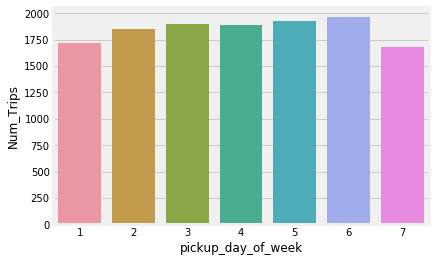

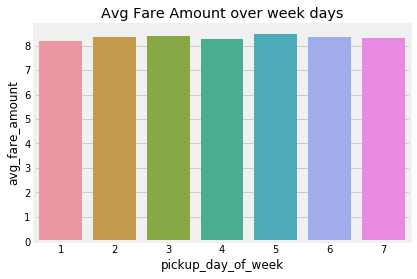

In [26]:
#pickup_day_of_week
No_trips_weekday=pd.DataFrame(Cab_train['pickup_day_of_week'].value_counts())
No_trips_weekday=No_trips_weekday.reset_index()
No_trips_weekday=No_trips_weekday.rename(columns={'index':'pickup_day_of_week','pickup_day_of_week':'Num_Trips'})


sns.barplot(x='pickup_day_of_week',y='Num_Trips',data=No_trips_weekday)
plt.show()


trips_weekday_fareamount=Cab_train.groupby(['pickup_day_of_week'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_day_of_week',y='avg_fare_amount',data=trips_weekday_fareamount).set_title("Avg Fare Amount over week days")
plt.show()

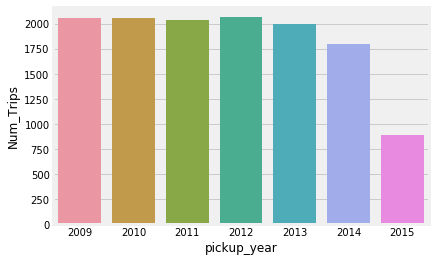

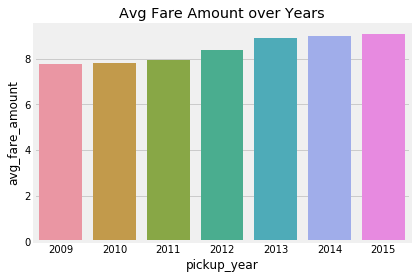

In [45]:
#pickup_year
no_trips_year=pd.DataFrame(Cab_train['pickup_year'].value_counts())
no_trips_year=no_trips_year.reset_index()
no_trips_year=no_trips_year.rename(columns={'index':'pickup_year','pickup_year':'Num_Trips'})


no_trips_year.head()
sns.barplot(x='pickup_year',y='Num_Trips',data=no_trips_year)
plt.show()


trips_year_fareamount=Cab_train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")
plt.show()

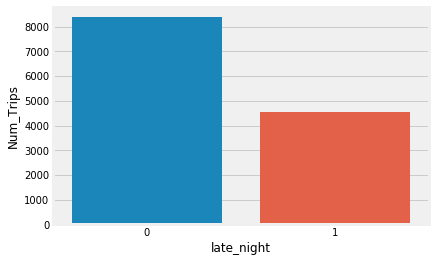

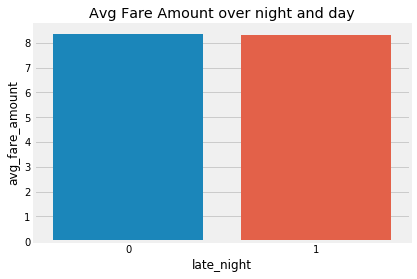

In [46]:
#late_night
no_trips_night=pd.DataFrame(Cab_train['late_night'].value_counts())
no_trips_night=no_trips_night.reset_index()
no_trips_night=no_trips_night.rename(columns={'index':'late_night','late_night':'Num_Trips'})


sns.barplot(x='late_night',y='Num_Trips',data=no_trips_night)
plt.show()


trips_night_fareamount=Cab_train.groupby(['late_night'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='late_night',y='avg_fare_amount',data=trips_night_fareamount).set_title("Avg Fare Amount over night and day")
plt.show()

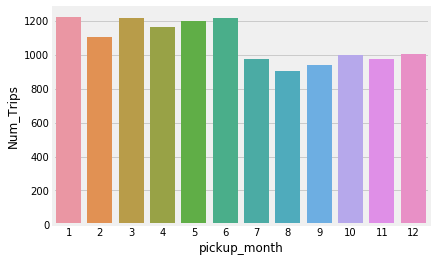

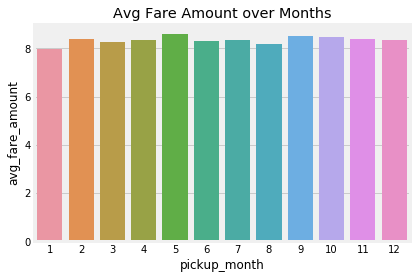

In [47]:
#pickup_month
no_trips_month=pd.DataFrame(Cab_train['pickup_month'].value_counts())
no_trips_month=no_trips_month.reset_index()
no_trips_month=no_trips_month.rename(columns={'index':'pickup_month','pickup_month':'Num_Trips'})


sns.barplot(x='pickup_month',y='Num_Trips',data=no_trips_month)
plt.show()

trips_month_fareamount=Cab_train.groupby(['pickup_month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_month',y='avg_fare_amount',data=trips_month_fareamount).set_title("Avg Fare Amount over Months")
plt.show()

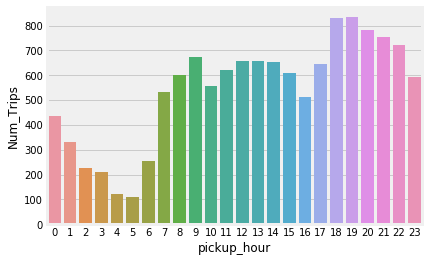

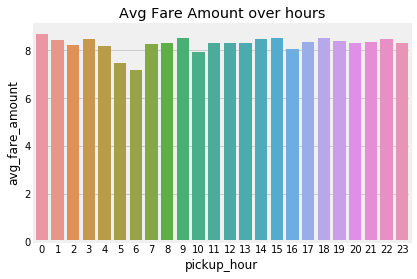

In [50]:
#pickup_hour
trips_hour=pd.DataFrame(Cab_train['pickup_hour'].value_counts())
trips_hour=trips_hour.reset_index()
trips_hour=trips_hour.rename(columns={'index':'pickup_hour','pickup_hour':'Num_Trips'})


sns.barplot(x='pickup_hour',y='Num_Trips',data=trips_hour)
plt.show()

trips_hour_fareamount=Cab_train.groupby(['pickup_hour'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_hour',y='avg_fare_amount',data=trips_hour_fareamount).set_title("Avg Fare Amount over hours")
plt.show()

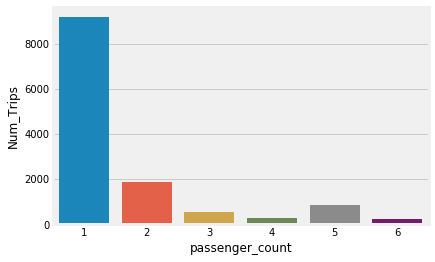

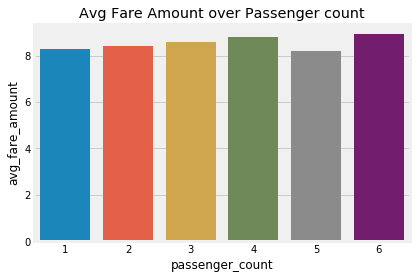

In [51]:
#passenger_count
pass_count=pd.DataFrame(Cab_train['passenger_count'].value_counts())
pass_count=pass_count.reset_index()
pass_count=pass_count.rename(columns={'index':'passenger_count','passenger_count':'Num_Trips'})


sns.barplot(x='passenger_count',y='Num_Trips',data=pass_count)
plt.show()


pass_count_fareamount=Cab_train.groupby(['passenger_count'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='passenger_count',y='avg_fare_amount',data=pass_count_fareamount).set_title("Avg Fare Amount over Passenger count")
plt.show()

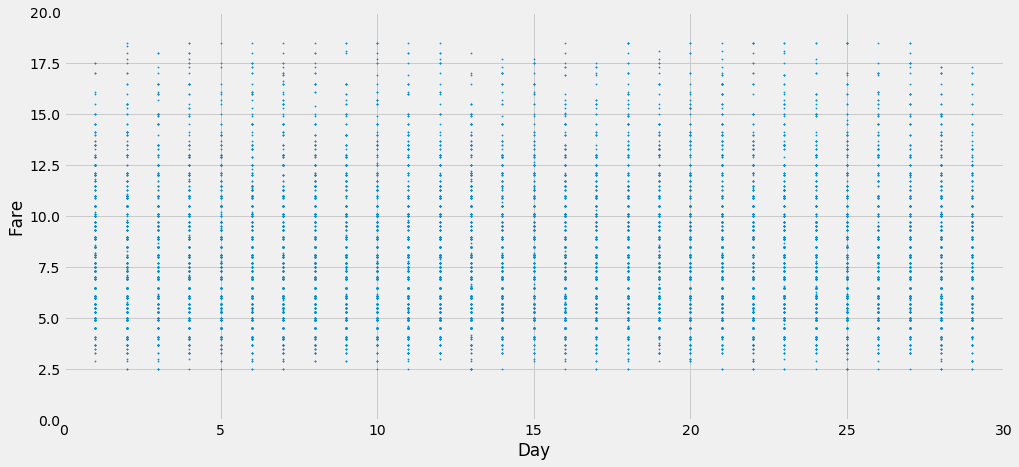

In [141]:
##pickup_day

plt.figure(figsize=(15,7))
plt.scatter(x=Cab_train['pickup_day'], y=Cab_train['fare_amount'], s=1.5)
plt.xlabel('Day')
plt.ylabel('Fare')
plt.axis([0, 30, 0, 20])
plt.show()

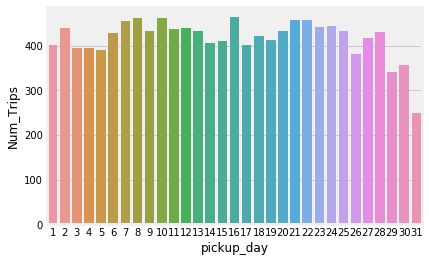

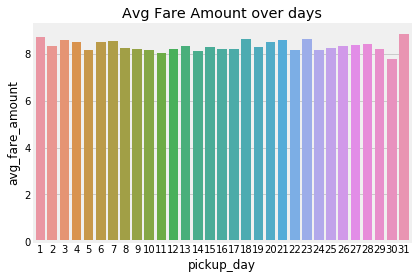

In [53]:
##pickup_day
trips_day=pd.DataFrame(Cab_train['pickup_day'].value_counts())
trips_day=trips_day.reset_index()
trips_day=trips_day.rename(columns={'index':'pickup_day','pickup_day':'Num_Trips'})


sns.barplot(x='pickup_day',y='Num_Trips',data=trips_day)
plt.show()

trips_day_fareamount=Cab_train.groupby(['pickup_day'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_day',y='avg_fare_amount',data=trips_day_fareamount).set_title("Avg Fare Amount over days")
plt.show()

In [27]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [Cab_train, Cab_test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [28]:
Cab_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,late_night,great_circle,geodesic
count,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000,12934.000000
mean,8.333746,-73.981747,40.753049,-73.980880,40.753515,1.648137,15.677362,13.671486,4.011288,6.217102,2011.684862,0.351631,1.395957,1.395887
std,3.447371,0.016008,0.021059,0.016536,0.021860,1.267014,8.692780,6.342838,1.959348,3.452771,1.861672,0.477498,0.919137,0.918645
min,2.500000,-74.018108,40.692830,-74.019535,40.692483,1.000000,1.000000,0.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000
25%,5.700000,-73.992737,40.738713,-73.991953,40.739216,1.000000,8.000000,9.000000,2.000000,3.000000,2010.000000,0.000000,0.723547,0.724068
50%,7.700000,-73.982636,40.753610,-73.982016,40.754677,1.000000,16.000000,14.000000,4.000000,6.000000,2012.000000,0.000000,1.165315,1.166058
75%,10.500000,-73.971350,40.766820,-73.970679,40.767386,2.000000,23.000000,19.000000,6.000000,9.000000,2013.000000,1.000000,1.846101,1.845964
max,18.500000,-73.931787,40.811077,-73.929738,40.812595,6.000000,31.000000,23.000000,7.000000,12.000000,2015.000000,1.000000,6.164333,6.158285


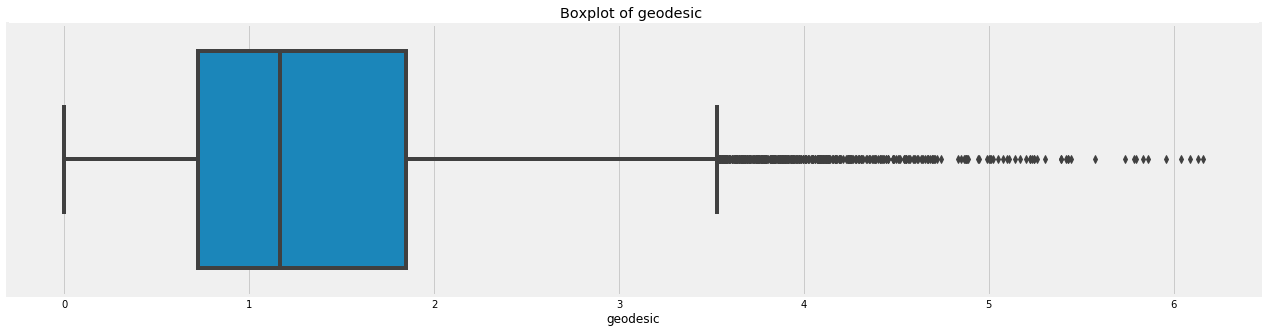

In [29]:
#Checking outliers in geodesic
plt.figure(figsize=(20,5)) 
sns.boxplot(x=Cab_train['geodesic'],data=Cab_train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()


In [30]:
# #Detect and delete outliers from data
q75, q25 = np.percentile(Cab_train.loc[:,'geodesic'], [75 ,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)
print(min)
print(max)
    
Cab_train = Cab_train.drop(Cab_train[Cab_train.loc[:,'geodesic'] < min].index)
Cab_train = Cab_train.drop(Cab_train[Cab_train.loc[:,'geodesic'] > max].index)

-0.9587762759928581
3.5288073949811958


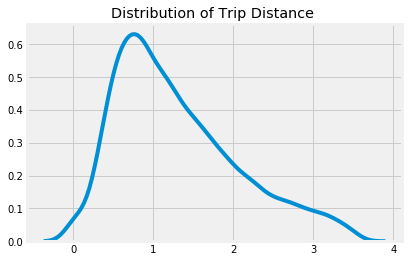

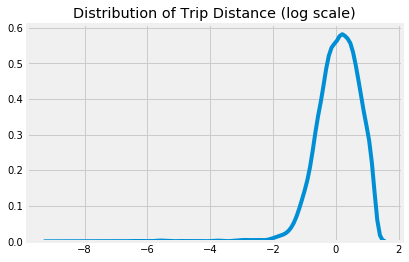

In [31]:
#Plotting the distribution of Distance covered
sns.kdeplot((Cab_train['geodesic'].values)).set_title("Distribution of Trip Distance ")
plt.show()
sns.kdeplot(np.log(Cab_train['geodesic'].values)).set_title("Distribution of Trip Distance (log scale)")
plt.show()

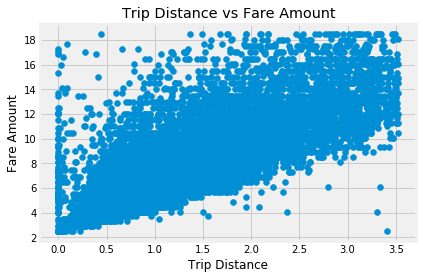

In [32]:
#Plot of Distance VS Fare
plt.scatter(x=Cab_train['geodesic'],y=Cab_train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")
plt.show()

In [33]:
df2=Cab_train.copy()
dfT=Cab_test.copy()
#cab_train=df2.copy()

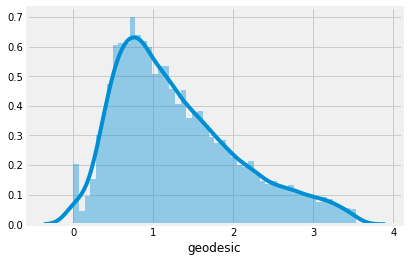

In [34]:
sns.distplot(Cab_train['geodesic'],bins=50)
# plt.savefig('distplot.png')

((array([-3.86506329, -3.64290312, -3.52107171, ...,  3.52107171,
          3.64290312,  3.86506329]),
  array([0.        , 0.        , 0.        , ..., 0.99860303, 0.99871514,
         1.        ])),
 (0.21176140857217782, 0.3679344582637862, 0.9715741545543277))

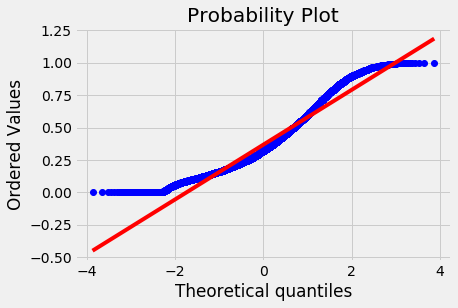

In [215]:
import scipy.stats as stats
plt.figure()
stats.probplot(Cab_train['geodesic'], dist='norm', fit=True,plot=plt)
# plt.savefig('qq prob plot.png')

In [35]:
#Normalization
Cab_train['geodesic'] = (Cab_train['geodesic'] - np.min(Cab_train['geodesic']))/(np.max(Cab_train['geodesic']) - np.min(Cab_train['geodesic']))
Cab_test['geodesic'] = (Cab_test['geodesic'] - np.min(Cab_test['geodesic']))/(np.max(Cab_test['geodesic']) - np.min(Cab_test['geodesic']))

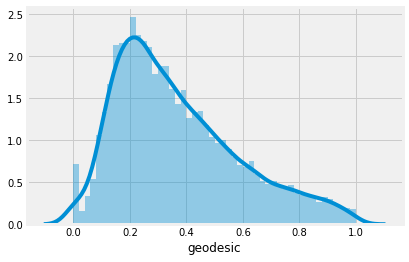

In [36]:
sns.distplot(Cab_train['geodesic'],bins=50)

In [37]:
Cab_train['geodesic'].var()

0.047481249795667466

In [45]:
#Cab_train = Cab_train.drop(['pickup_datetime'], axis=1)
Cab_train = Cab_train.drop(['pickup_date'],axis=1)

In [52]:

#Drop unnecessary variables and divide Training set into train and validation set

#Cab_train = Cab_train.drop(['pickup_datetime'], axis=1)
#Cab_train = Cab_train.drop(['pickup_date']
y = Cab_train['fare_amount']
X = Cab_train.drop(['fare_amount'],axis = 1)


###Drop columns on test data
#Cab_test = Cab_test.drop(['pickup_datetime'],axis = 1)
Cab_test = Cab_test.drop(['pickup_date'],axis=1)

In [55]:
Cab_train.shape

(12482, 14)

In [56]:
#25% Validation set
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.25)

In [190]:
Cab_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12482 entries, 2 to 16065
Data columns (total 14 columns):
fare_amount           12482 non-null float64
pickup_longitude      12482 non-null float64
pickup_latitude       12482 non-null float64
dropoff_longitude     12482 non-null float64
dropoff_latitude      12482 non-null float64
passenger_count       12482 non-null int64
pickup_day            12482 non-null int64
pickup_hour           12482 non-null int64
pickup_day_of_week    12482 non-null int64
pickup_month          12482 non-null int64
pickup_year           12482 non-null int64
late_night            12482 non-null int64
great_circle          12482 non-null float64
geodesic              12482 non-null float64
dtypes: float64(7), int64(7)
memory usage: 1.4 MB


# Model Development 

In [57]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
   

## Decision Tree Regression

In [58]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 4}
Best score is 0.6378003594889797


[0.00435383 0.0009874  0.00208352 0.00480357 0.         0.00091674
 0.0059383  0.         0.00354377 0.05702772 0.0126548  0.03036813
 0.87732222]


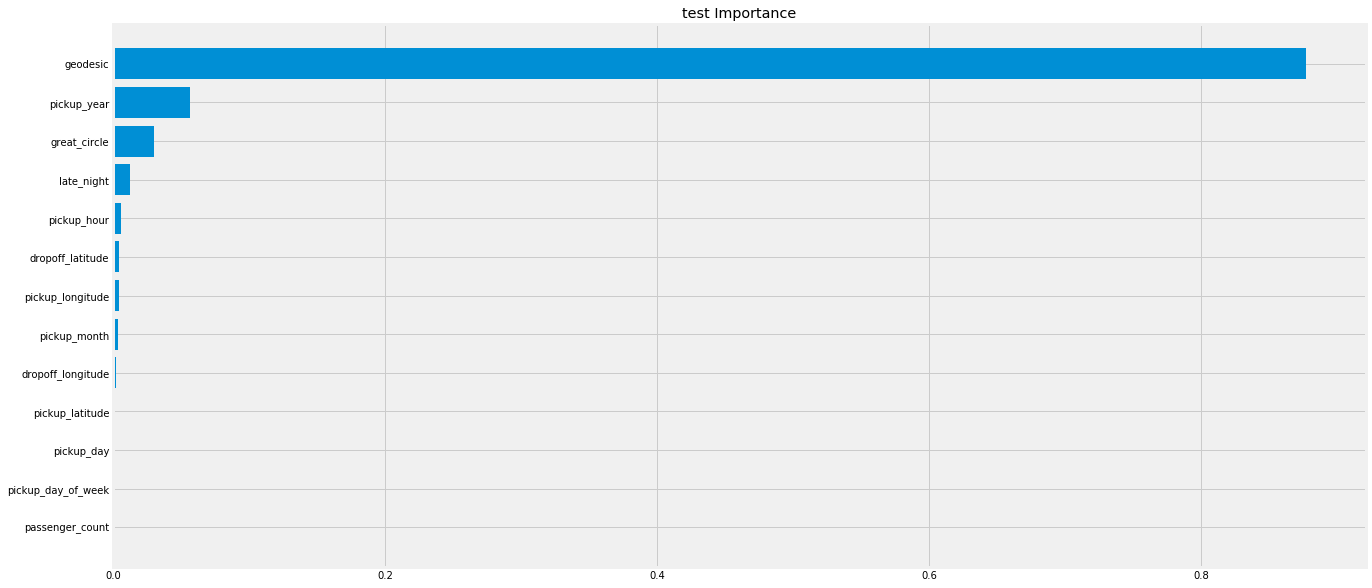

<<<------------------- Training Data Score --------------------->

r square   0.6759851252920315
Adjusted r square:0.6755344787347186
MAPE:17.24420035961592
RMSE: 1.8182678215178951

<<<------------------- Test Data Score --------------------->

r square   0.6391940260795843
Adjusted r square:0.6376843776531391
MAPE:17.994384710217158
RMSE: 1.9336111504059643


In [59]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=4)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [Cab_test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Linear Regression

In [60]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.6495842113491038


R^2: 0.6488035889552841
Root Mean Squared Error: 1.9076878625659281
<<<------------------- Training Data Score --------------------->

r square   0.6509166970439839
Adjusted r square:0.6504311848006514
MAPE:17.702833767265542
RMSE: 1.8872955556283124

<<<------------------- Test Data Score --------------------->

r square   0.6488035889552841
Adjusted r square:0.6473341479048877
MAPE:17.92035141825923
RMSE: 1.9076878625659281
[-2.70678267e+00  1.96591877e+00 -3.88307790e+00 -7.16360499e+00
  5.10266990e-02  2.07277436e-03  1.75873709e-02 -1.71608003e-02
  4.64318316e-02  3.26702486e-01 -7.62660901e-01 -1.97626535e+02
  7.08920724e+02]


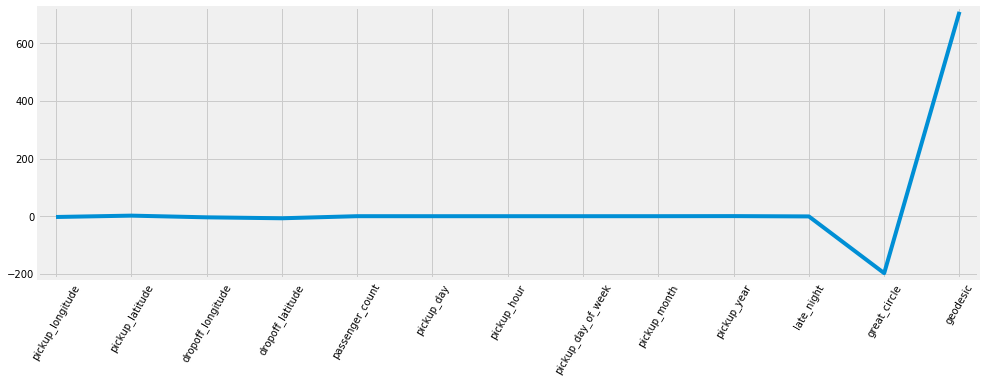

In [61]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(Cab_test.columns)), reg_coef)
plt.xticks(range(len(Cab_test.columns)), Cab_test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

## Random Forest

In [62]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': False}
Best score is 0.6873276470522499


[0.03164039 0.03502175 0.03163833 0.04112095 0.00635663 0.01769075
 0.02249496 0.01420423 0.01725168 0.04763963 0.00928393 0.38046165
 0.34519513]


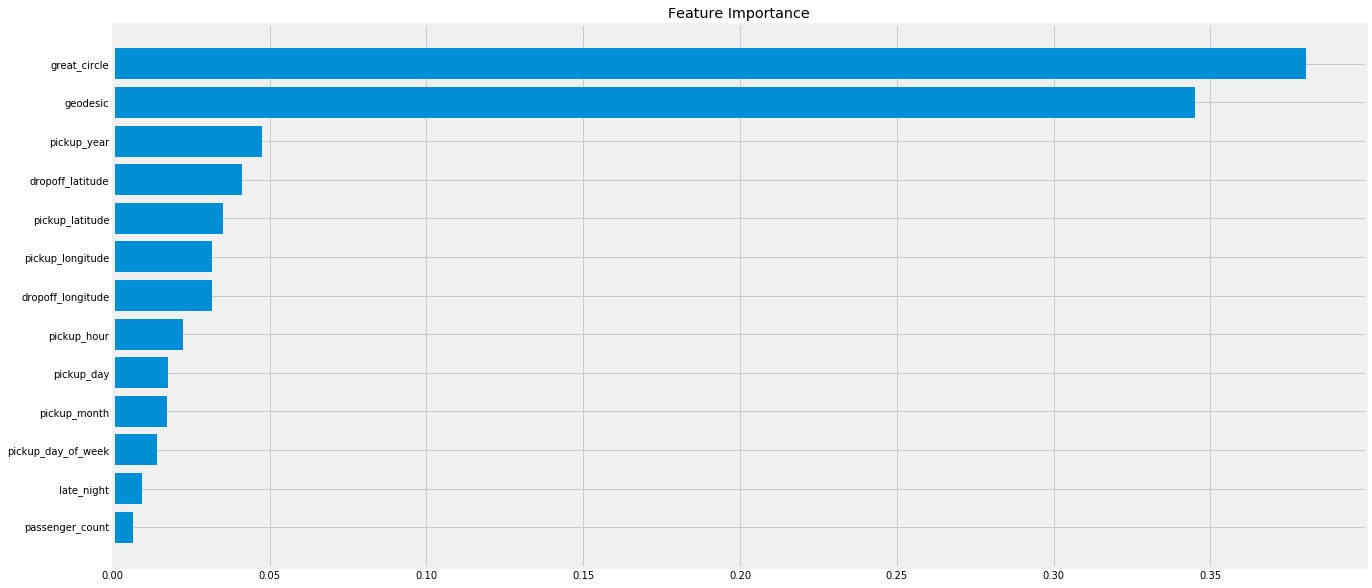

<<<------------------- Training Data Score --------------------->

r square   0.9397106332444995
Adjusted r square:0.9396267815522109
MAPE:6.744788724206718
RMSE: 0.7843244255515974

<<<------------------- Test Data Score --------------------->

r square   0.6804525962598367
Adjusted r square:0.6791155778341456
MAPE:16.90922917401351
RMSE: 1.8197005597982328


In [64]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=300, min_samples_split= 4, min_samples_leaf=3, max_features='sqrt', max_depth=18, bootstrap=False)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [Cab_test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

## XGBOOST

In [67]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

[16:39:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNI

[16:43:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.03558831 0.03031121 0.04751259 0.03965991 0.01379091 0.01648034
 0.02691714 0.02087018 0.02207658 0.08754644 0.05452408 0.27554253
 0.32917985]


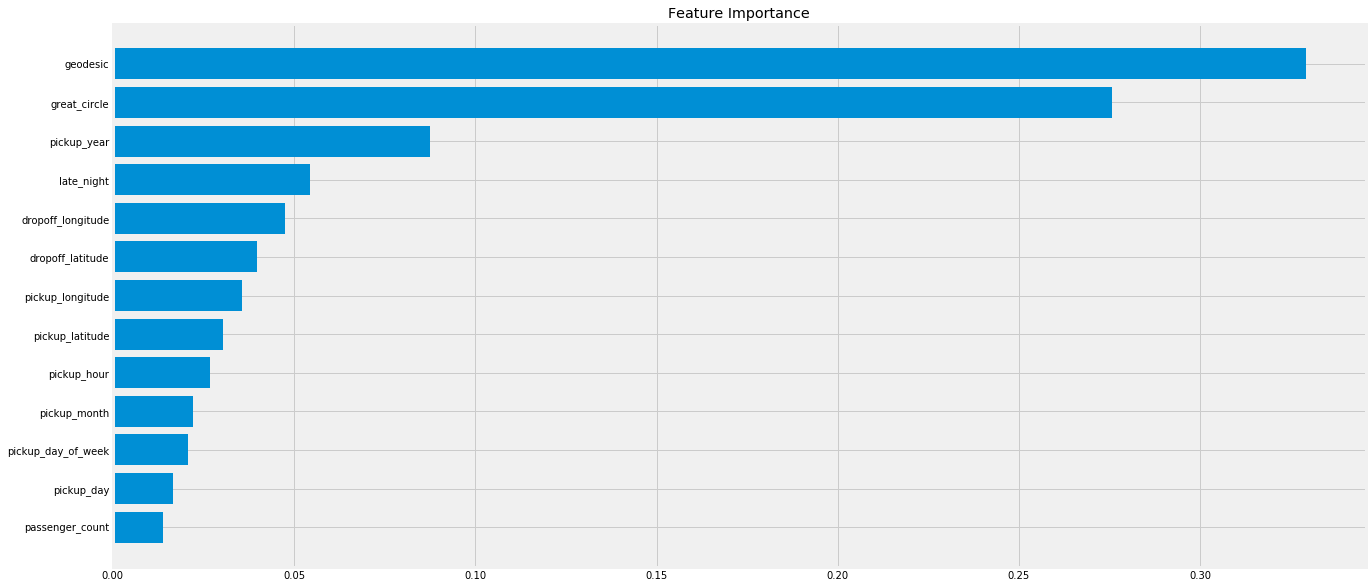

<<<------------------- Training Data Score --------------------->

r square   0.8973133744273231
Adjusted r square:0.8971705557547602
MAPE:9.793984328712876
RMSE: 1.0236048152025392

<<<------------------- Test Data Score --------------------->

r square   0.7022548565324075
Adjusted r square:0.7010090609530453
MAPE:16.470292626182633
RMSE: 1.756526172479898


In [68]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.9000000000000001, reg_alpha=   0.0011513953993264468, n_estimators= 400, max_depth= 5, learning_rate= 0.15000000000000002,
                   colsample_bytree= 0.7000000000000001, colsample_bynode=0.5000000000000001, colsample_bylevel=0.5000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [Cab_test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

# Finalize model

Create standalone model on entire training dataset and
Save model for later use

In [77]:

def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))

In [70]:
test_data=pd.read_csv('test.csv')

In [71]:
test_pickup_datetime=test_data['pickup_datetime']

[16:50:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.03163542 0.03105691 0.04312714 0.03716621 0.01413951 0.01558933
 0.02593329 0.01943849 0.02088184 0.10014623 0.04591875 0.40232328
 0.21264356]


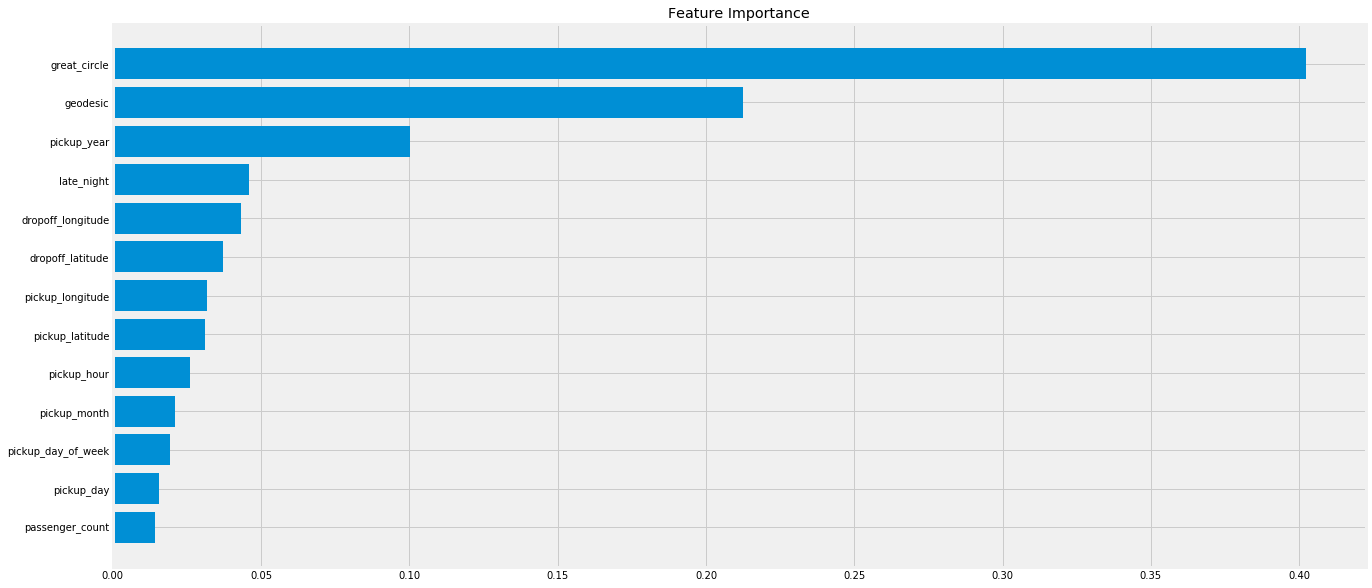

<<<------------------- Training Data Score --------------------->

r square   0.8769807106603733
Adjusted r square:0.8768524422322842
MAPE:10.72824650048165
MSE: 1.2601635015105397
RMSE: 1.1225700430309637
RMSLE: 0.12174482797619744


In [78]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.9000000000000001, reg_alpha=   0.0011513953993264468, n_estimators= 400, max_depth= 5, learning_rate= 0.15000000000000002,
                   colsample_bytree= 0.7000000000000001, colsample_bynode=0.5000000000000001, colsample_bylevel=0.5000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [Cab_test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
scores(Xgb)


Thank you